In [4]:
#necessary library
import os
import requests
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import os
import re
import emoji

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
import nltk
nltk.download('stopwords')
sw = stopwords.words("english")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns
import html 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Blaven/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Blaven/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Blaven/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Blaven/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Loading 

In [5]:
#loading data 
df = pd.read_csv("/Users/Blaven/Downloads/fake_job_postings.csv")
df.head(5)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## Exploratory Data Analysis(EDA)

In this section we will be exploring our data by looking at the various aspects such as checking null values, duplicates, class imbalance, data types. 

### Checking Null Values

In [6]:
#to checking null values
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
#checking data shape
df.shape

(17880, 18)

### Information on Missing Values

In [8]:
#sustituting null values with na 
df_na =df.fillna('na') 

real=df_na[df_na.fraudulent==0]
fake=df_na[df_na.fraudulent==1]



In [9]:
#cheching the rates of na 
na_rates=pd.DataFrame([col, len(real.loc[real[col]=='na'])/len(real[col]), len(fake.loc[fake[col]=='na'])/len(fake[col]) ] for col in df.columns)

na_rates.columns=['column','real_na_rates','fake_na_rates']


In [10]:
na_rates

,column,real_na_rates,fake_na_rates
0,job_id,0.000000,0.000000
1,title,0.000000,0.000000
2,location,0.019219,0.021940
3,department,0.647467,0.613164
4,salary_range,0.844540,0.742494
5,company_profile,0.159927,0.677829
6,description,0.000000,0.001155
7,requirements,0.149348,0.177829
8,benefits,0.402433,0.420323
9,telecommuting,0.000000,0.000000


In [11]:
#z-test on null values 
from statsmodels.stats.proportion import proportions_ztest
for col in df.columns:
    counts=np.array([len(real.loc[real[col]=='na']), len(fake.loc[fake[col]=='na'])])
    nobs=np.array([len(real[col]), len(fake[col])])
    if (counts.sum() !=0) and (nobs.sum() !=0):
        na_rates.loc[na_rates.column==col,'zstat'], na_rates.loc[na_rates.column==col,'p_value']=proportions_ztest(count=counts, nobs=nobs,  alternative='two-sided')

In [12]:
na_rates['significant_diff']=na_rates['p_value']<0.005
na_rates

,column,real_na_rates,fake_na_rates,zstat,p_value,significant_diff
0,job_id,0.000000,0.000000,NaN,NaN,False
1,title,0.000000,0.000000,NaN,NaN,False
2,location,0.019219,0.021940,-0.566910,5.707753e-01,False
3,department,0.647467,0.613164,2.058905,3.950329e-02,False
4,salary_range,0.844540,0.742494,7.982358,1.435640e-15,True
5,company_profile,0.159927,0.677829,-38.286984,0.000000e+00,True
6,description,0.000000,0.001155,-4.432578,9.311288e-06,True
7,requirements,0.149348,0.177829,-2.285189,2.230177e-02,False
8,benefits,0.402433,0.420323,-1.046881,2.951542e-01,False
9,telecommuting,0.000000,0.000000,NaN,NaN,False


**Observation**

The Z-tests indicate that differences of na-rates among real and fake job-postings are mostly statistically significant, except in 'location', 'department', 'benefits' and 'function'. The difference is largest in company profile, where 68% of fake ads do not have a company profile, but only 16.1% of real ads omit company profiles.

### Checking Data Types 

In [13]:
#obtaining data types
df.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

### Checking Duplicates 

In [14]:
#counting duplicate value
df.duplicated().value_counts()

False    17880
dtype: int64

**Observation:** 

No duplicates identified. 

In [15]:
# statististics of numeric data 
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


**From describe() fuctution we can see our data has 4 numerical columns named as job_id, telecommuting, has_company_logo and has_questions.We can  remove these columns as they are of no use in text classification problems. We can see another numerical feature 'fraudulent' but here this columns will be used as our target variable in which the models will be trained and predicted.**

### Checking Class Imbalance 

,fraudulent,title
0,0,17014
1,1,866


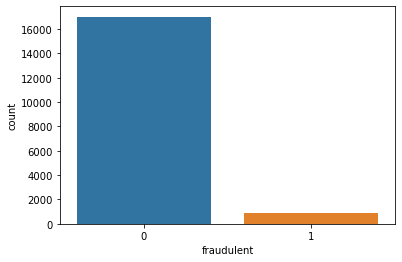

In [16]:
# Now lets see how many jobs posted are fraud and real.
plt.title("")
sns.countplot(df.fraudulent)
df.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

**Filling NAs with empty string**

In [17]:
#filling na with empty space
df.fillna(' ', inplace=True)

In [18]:
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,0,0,Full-time,,,,,0
17878,17879,Graphic Designer,"NG, LA, Lagos",,,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


#### Total Job posting by countries and Total fake job posting by countries

In [19]:
#obtaining country name by splitting location
def split(location):
    l = location.split(',')
    return l[0]

df['country'] = df.location.apply(split)

Text(0.5, 0, 'Countries')

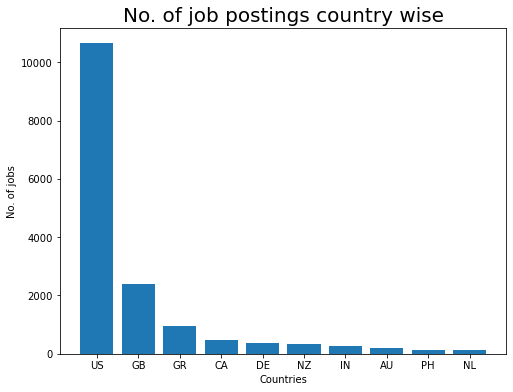

In [20]:
country = dict(df.country.value_counts()[:11])
del country[' ']
plt.figure(figsize=(8,6))
plt.title('No. of job postings country wise', size=20)
plt.bar(country.keys(), country.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)

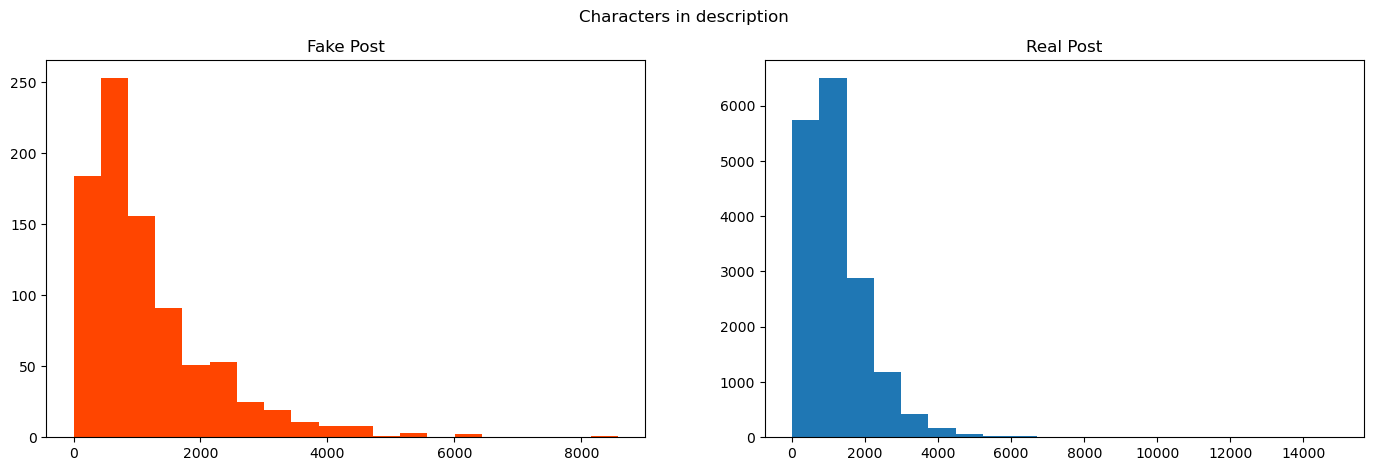

In [21]:
#distribution of characters in description feature 

fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length= df[df["fraudulent"]==1]['description'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=df[df["fraudulent"]==0]['description'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in description')
plt.show()

In [22]:
df.head(10)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,US
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,US
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US
5,6,Accounting Clerk,"US, MD,",,,,Job OverviewApex is an environmental consultin...,,,0,0,0,,,,,,0,US
6,7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0,DE
7,8,Lead Guest Service Specialist,"US, CA, San Francisco",,,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,,,,,,0,US
8,9,HP BSM SME,"US, FL, Pensacola",,,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,,0,1,1,Full-time,Associate,,Information Technology and Services,,0,US
9,10,Customer Service Associate - Part Time,"US, AZ, Phoenix",,,"Novitex Enterprise Solutions, formerly Pitney ...",The Customer Service Associate will be based i...,Minimum Requirements:Minimum of 6 months custo...,,0,1,0,Part-time,Entry level,High School or equivalent,Financial Services,Customer Service,0,US


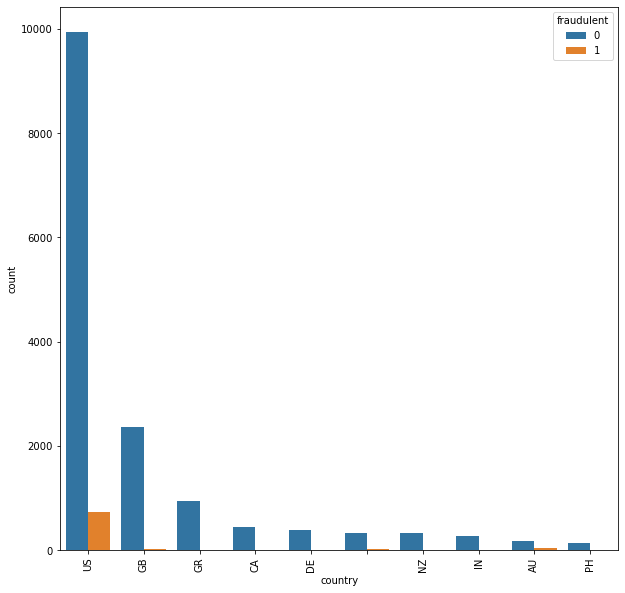

In [23]:
#countplot as per country
plt.figure(figsize=(10,10))
sns.countplot(x='country', data=df, hue="fraudulent", order=df['country'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)
plt.show()


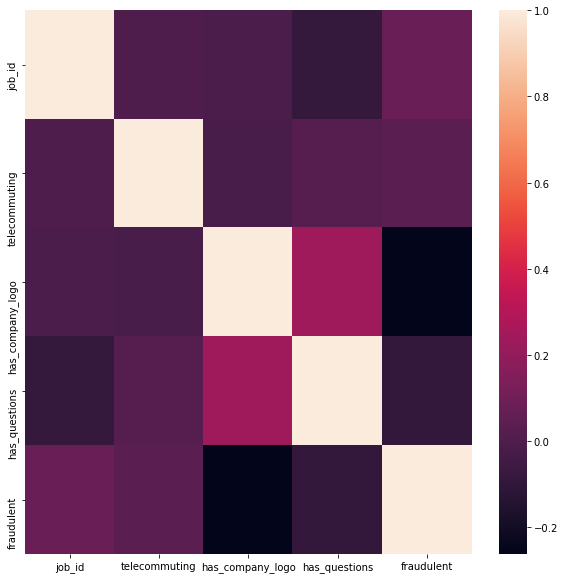

In [24]:
#heatmap fpr correlation of numeeric features 
corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr)
plt.show()



In [25]:
#subsetting fake and real data 
fake=df[df.fraudulent==1]
#fake
real = df[df.fraudulent==0]

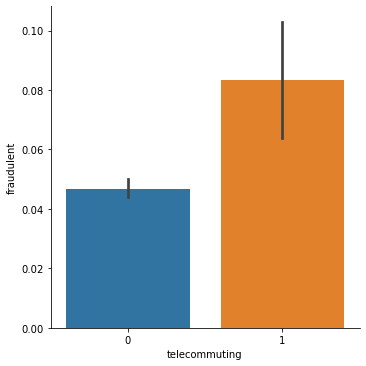

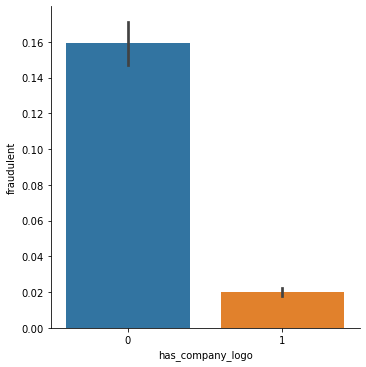

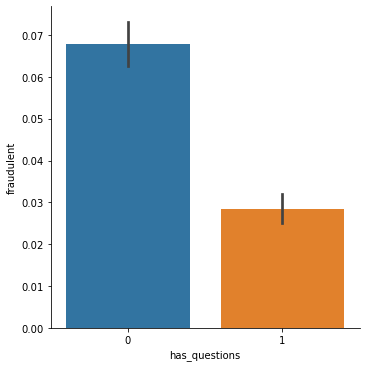

In [26]:
#categorical plots to cheeck relationship of binary features with fradulent transaction 
sns.catplot(data=df,y='fraudulent', x='telecommuting', kind='bar')
sns.catplot(data=df, y='fraudulent', x='has_company_logo', kind='bar')
sns.catplot(data=df, y='fraudulent', x='has_questions', kind='bar')

**Observation**

The following graphs of three binary features show that ads of jobs involving telecommuting, do not have company logo and screening questions are more likely to be fake. Among the three features, the absence of company logo is the most indicative, with 16% of ads without company logo to be fake, while only 2% of ads with company logo are fraudulent.



Text(0.5, 0, 'Countries')

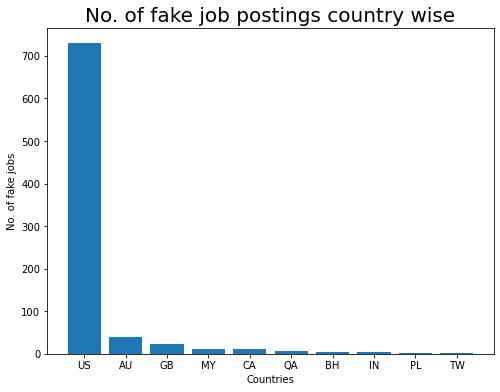

In [27]:
#barplot for visualization of data points in each countries for both fake jobs 
country = dict(fake.country.value_counts()[:11])
del country[' ']
plt.figure(figsize=(8,6))
plt.title('No. of fake job postings country wise', size=20)
plt.bar(country.keys(), country.values())
plt.ylabel('No. of fake jobs', size=10)
plt.xlabel('Countries', size=10)

Text(0.5, 0, 'Countries')

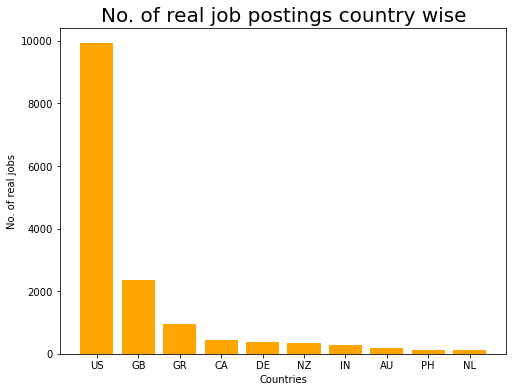

In [28]:
#barplot for visualization of data points in each countries for both real jobs 

country = dict(real.country.value_counts()[:11])
del country[' ']
plt.figure(figsize=(8,6))
plt.title('No. of real job postings country wise', size=20)
plt.bar(country.keys(), country.values(), color ='orange')
plt.ylabel('No. of real jobs', size=10)
plt.xlabel('Countries', size=10)

**Observation:**

It looks like United states has most job posting in the data compared to other countries and even the fake job posting are mostly in the United states and other countries has very less amount of fake job posting. 


#### Fake job postings by title.

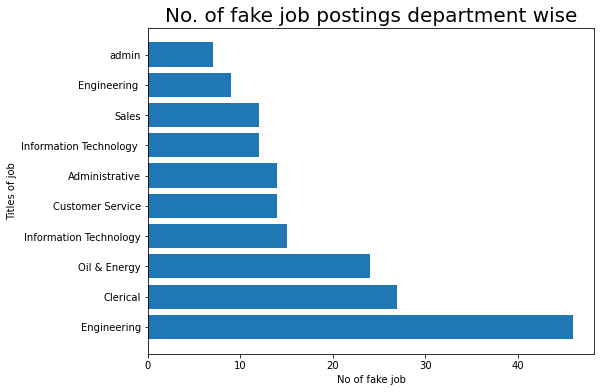

In [29]:
#barplot of job postings by title of job

titles = dict(fake.department.value_counts()[:11])
del titles[' ']
plt.figure(figsize=(8,6))
plt.title('No. of fake job postings department wise', size=20)
names = list(titles.keys())
values = list(titles.values())

plt.barh(range(len(titles)), values, tick_label=names)
plt.ylabel('Titles of job', size=10)
plt.xlabel('No of fake job', size=10)
plt.show()



### Difference in characters of description of fake jobs and real jobs

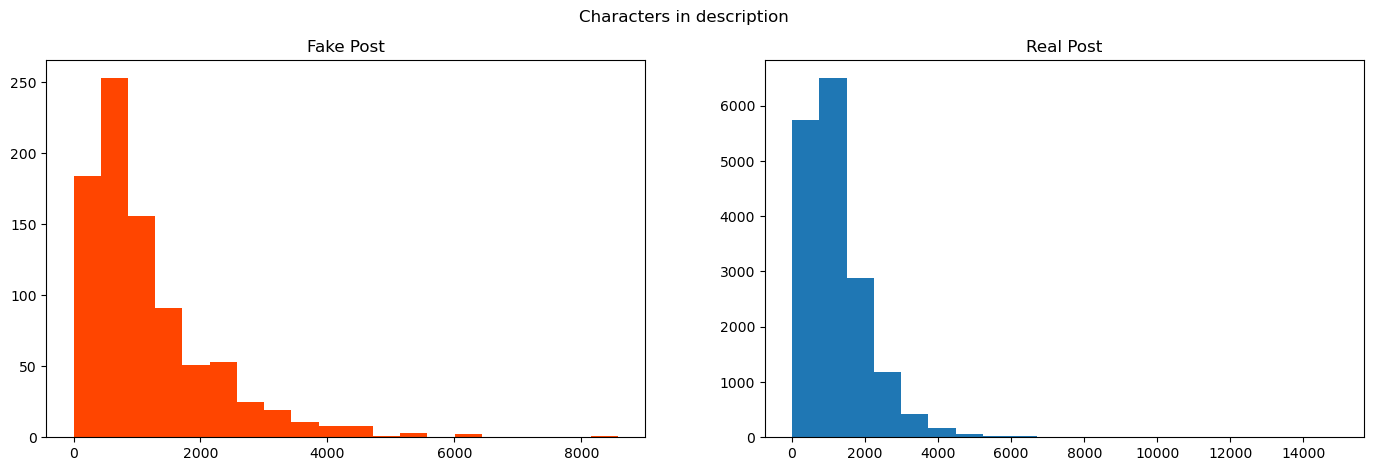

In [30]:
fig,(ax1,ax2)= plt.subplots(ncols=2, figsize=(17, 5), dpi=100)
length= df[df["fraudulent"]==1]['description'].str.len()
ax1.hist(length,bins = 20,color='orangered')
ax1.set_title('Fake Post')
length=df[df["fraudulent"]==0]['description'].str.len()
ax2.hist(length, bins = 20)
ax2.set_title('Real Post')
fig.suptitle('Characters in description')
plt.show()

## Data Preparation

Merging seven text column which are significant on determining real and fakee jobs. The features “title”, “company profile”, “description”, “employment_type”, “required_experience” , “required education” and “industry” were combined into a single feature called “text” 


In [31]:
#combining significant text features 
df['text']=df.title+' '+df.company_profile+' '+df.description+' '+df.employment_type+' '+df.required_experience+' '+df.required_education+' '+df.industry



In [32]:
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,text
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,US,"Marketing Intern We're Food52, and we've creat..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ,Customer Service - Cloud Video Production 90 S...
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,US,Commissioning Machinery Assistant (CMA) Valor ...
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,Account Executive - Washington DC Our passion ...
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Bill Review Manager SpotSource Solutions LLC i...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,,Computer Software,Sales,0,CA,Account Director - Distribution Vend is looki...
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US,Payroll Accountant WebLinc is the e-commerce p...
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,0,0,Full-time,,,,,0,US,Project Cost Control Staff Engineer - Cost Con...
17878,17879,Graphic Designer,"NG, LA, Lagos",,,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,NG,Graphic Designer Nemsia Studios is looking f...


In [33]:
#counting characters in text feature for each data points 
df['character_count'] = df['text'].str.len()



In [34]:
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,text,character_count
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,...,0,Other,Internship,,,Marketing,0,US,"Marketing Intern We're Food52, and we've creat...",1829
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ,Customer Service - Cloud Video Production 90 S...,3459
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,...,0,,,,,,0,US,Commissioning Machinery Assistant (CMA) Valor ...,1283
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,...,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,Account Executive - Washington DC Our passion ...,3312
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,...,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Bill Review Manager SpotSource Solutions LLC i...,3237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,...,1,Full-time,Mid-Senior level,,Computer Software,Sales,0,CA,Account Director - Distribution Vend is looki...,3231
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,...,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US,Payroll Accountant WebLinc is the e-commerce p...,3560
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,...,0,Full-time,,,,,0,US,Project Cost Control Staff Engineer - Cost Con...,1596
17878,17879,Graphic Designer,"NG, LA, Lagos",,,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,...,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,NG,Graphic Designer Nemsia Studios is looking f...,577


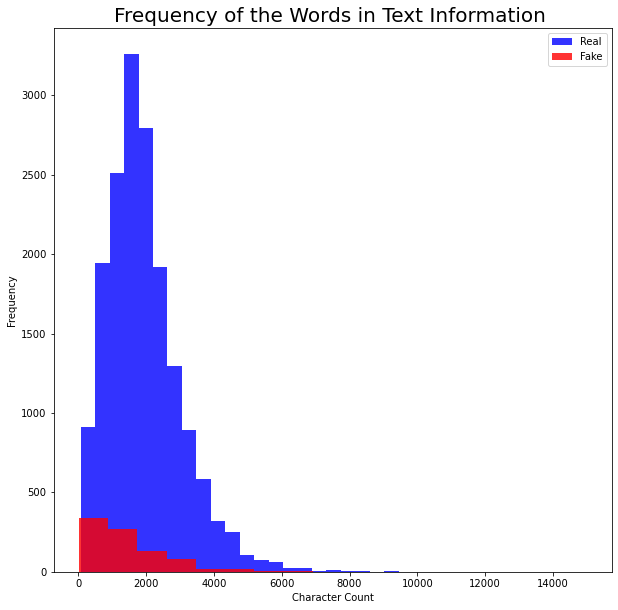

In [35]:
#frequency plot for distribution of words on text

plt.figure(figsize=(10,10))

df[df.fraudulent==0].character_count.plot(bins=35, kind='hist', color='blue', 
                                       label='Real', alpha=0.8)
df[df.fraudulent==1].character_count.plot(kind='hist', color='red', 
                                       label='Fake', alpha=0.8)
plt.legend()
plt.title('Frequency of the Words in Text Information ',size=20)
plt.xlabel("Character Count",size=10);

**The distribution of charaters in description of the fake and real post are similar. Some fake post reach to 6000 to 8000 characters.**

## Data Cleaning and Preprocessing

#### Selecting features relavant for text classification. 

In [36]:
#subsetting necessary features
features = ['text', 'fraudulent']

In [37]:
#making new data frame with relavant features 
df_new = df[features]
df_new

,text,fraudulent
0,"Marketing Intern We're Food52, and we've creat...",0
1,Customer Service - Cloud Video Production 90 S...,0
2,Commissioning Machinery Assistant (CMA) Valor ...,0
3,Account Executive - Washington DC Our passion ...,0
4,Bill Review Manager SpotSource Solutions LLC i...,0
...,...,...
17875,Account Director - Distribution Vend is looki...,0
17876,Payroll Accountant WebLinc is the e-commerce p...,0
17877,Project Cost Control Staff Engineer - Cost Con...,0
17878,Graphic Designer Nemsia Studios is looking f...,0


In [38]:
df_new["text"][1]

"Customer Service - Cloud Video Production 90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world. 90 Seconds makes video production fast, affordable, and all managed seamlessly in the cloud from purchase to publish. http://90#URL_fbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630#90 Seconds removes the hassle, cost, risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience. With a growing global network of over 2,000 rated video professionals in over 50 countries managed by dedicated production success teams in 5 countries, 90 Seconds provides a 100% success guarantee.90 Seconds has produced almost 4,000 videos in over 30 Countries for over 500 Global brands including some of the worlds largest including Paypal, L’Oreal

**Removing HTML tags from the dataframe**

In [39]:
#cleaning the html tags from the data 
for i in df.index:
    df_new.at[i, 'text'] = re.sub(r'https?://\S+', '', df_new.at[i, 'text'])
    

#testing if the code worked    
df_new["text"][1]

"Customer Service - Cloud Video Production 90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world. 90 Seconds makes video production fast, affordable, and all managed seamlessly in the cloud from purchase to publish.  Seconds removes the hassle, cost, risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience. With a growing global network of over 2,000 rated video professionals in over 50 countries managed by dedicated production success teams in 5 countries, 90 Seconds provides a 100% success guarantee.90 Seconds has produced almost 4,000 videos in over 30 Countries for over 500 Global brands including some of the worlds largest including Paypal, L’Oreal, Sony and Barclays and has offices in Auckland, London, Sydney, Tokyo and Singap

In [40]:
df_new

,text,fraudulent
0,"Marketing Intern We're Food52, and we've creat...",0
1,Customer Service - Cloud Video Production 90 S...,0
2,Commissioning Machinery Assistant (CMA) Valor ...,0
3,Account Executive - Washington DC Our passion ...,0
4,Bill Review Manager SpotSource Solutions LLC i...,0
...,...,...
17875,Account Director - Distribution Vend is looki...,0
17876,Payroll Accountant WebLinc is the e-commerce p...,0
17877,Project Cost Control Staff Engineer - Cost Con...,0
17878,Graphic Designer Nemsia Studios is looking f...,0


### Functions for Cleaning

1) Removing HTML tags

2) Removing punctuations

3) Removing Stop words

4) Removing Numerical values

5) Case Normalization 

6) Lemmatization

7) Tokenization

In [41]:
punctuation = set(punctuation)
import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# speeds up comparison

def remove_punc(text):
    text_nonpunc ="".join([char for char in text if char not in punctuation])
    return text_nonpunc

# Define Tokenization Function
#To keep the emojis while tokenizing
RE_TOKEN = re.compile(r"""
                   ( [#]?[@\w'’\.\-\:]*\w     # words, hashtags and email addresses
                   | [:;<]\-?[\)\(3]          # coarse pattern for basic text emojis
                   | [\U0001F100-\U0001FFFF]  # coarse code range for unicode emojis
                   )
                  """, re.VERBOSE)


    
def tokenize(text):
    return text.split()

# Define Stop Words Remove Function
stopwords = set(nltk.corpus.stopwords.words('english'))

#function for removing stop words 
def remove_stop(text, stop_words = sw) :
     # modify this function to remove stopwords .split(' ')
    return(" ".join([word for word in text.split(' ') if word not in stop_words ]))
 
#function for removing  punctuation

def remove_punctuation(text, punct_set=punctuation) : 
    return("".join([ch for ch in text if ch not in punct_set]))


#function for lemmmatization

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)

#function for reeemoving numeric data 

def remove_number(text):
    return (''.join([x for x in text if not x.isdigit()]))


# Define pipeline of lowering, no punctuation, tokenization, and removal of stopwords
pipeline1 = [str.lower,remove_stop,remove_punctuation,remove_number,lemmatize_words]


def prepare(text, pipeline): 
    tokens = text
    for transform in pipeline: tokens = transform(tokens)
    return tokens

### Removing Puctuations, Lower Casing and Removing Stop Words

In [42]:
#applying cleaning pipeline to the text data
df_new['clean_text'] = df_new['text'].apply(prepare, pipeline = pipeline1)

df_new

,text,fraudulent,clean_text
0,"Marketing Intern We're Food52, and we've creat...",0,market intern be food weve create groundbreaki...
1,Customer Service - Cloud Video Production 90 S...,0,customer service cloud video production second...
2,Commissioning Machinery Assistant (CMA) Valor ...,0,commission machinery assistant cma valor servi...
3,Account Executive - Washington DC Our passion ...,0,account executive washington dc passion improv...
4,Bill Review Manager SpotSource Solutions LLC i...,0,bill review manager spotsource solutions llc g...
...,...,...,...
17875,Account Director - Distribution Vend is looki...,0,account director distribution vend look awesom...
17876,Payroll Accountant WebLinc is the e-commerce p...,0,payroll accountant weblinc ecommerce platform ...
17877,Project Cost Control Staff Engineer - Cost Con...,0,project cost control staff engineer cost contr...
17878,Graphic Designer Nemsia Studios is looking f...,0,graphic designer nemsia studios look experienc...


In [43]:
df_new['clean_text'][1]

'customer service cloud video production second worlds cloud video production service second worlds cloud video production service enable brand agencies get high quality online video content shoot produce anywhere world second make video production fast affordable manage seamlessly cloud purchase publish second remove hassle cost risk speed issue work regular video production company manage every aspect video project beautiful online experience grow global network rat video professionals countries manage dedicate production success team countries second provide success guarantee second produce almost videos countries global brand include worlds largest include paypal l’oreal sony barclays offices auckland london sydney tokyo singapore organise focus vibrant awesomedo passion customer service slick type skills maybe account management and think administration cooler polar bear jetski need hear you we cloud video production service opperating glodal level yeah pretty cool serious about d

In [44]:
#applying cleaning pipeline to the text data

pipeline2= [tokenize]
df_new['token'] = df_new['clean_text'].apply(prepare, pipeline = pipeline2)

df_new

,text,fraudulent,clean_text,token
0,"Marketing Intern We're Food52, and we've creat...",0,market intern be food weve create groundbreaki...,"[market, intern, be, food, weve, create, groun..."
1,Customer Service - Cloud Video Production 90 S...,0,customer service cloud video production second...,"[customer, service, cloud, video, production, ..."
2,Commissioning Machinery Assistant (CMA) Valor ...,0,commission machinery assistant cma valor servi...,"[commission, machinery, assistant, cma, valor,..."
3,Account Executive - Washington DC Our passion ...,0,account executive washington dc passion improv...,"[account, executive, washington, dc, passion, ..."
4,Bill Review Manager SpotSource Solutions LLC i...,0,bill review manager spotsource solutions llc g...,"[bill, review, manager, spotsource, solutions,..."
...,...,...,...,...
17875,Account Director - Distribution Vend is looki...,0,account director distribution vend look awesom...,"[account, director, distribution, vend, look, ..."
17876,Payroll Accountant WebLinc is the e-commerce p...,0,payroll accountant weblinc ecommerce platform ...,"[payroll, accountant, weblinc, ecommerce, plat..."
17877,Project Cost Control Staff Engineer - Cost Con...,0,project cost control staff engineer cost contr...,"[project, cost, control, staff, engineer, cost..."
17878,Graphic Designer Nemsia Studios is looking f...,0,graphic designer nemsia studios look experienc...,"[graphic, designer, nemsia, studios, look, exp..."


## Descriptive Statistics of Data

In [45]:
#function for generating descriptive statistics 

def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    
    #filled na with whitespace to work with df and making sure it will
    #not be counted on frequent words
    tokens = [token for token in tokens if token not in ['', " "]]
    # Fill in the correct values here. 
    num_tokens =  len(tokens)
    num_unique_tokens = len(set(tokens)) #len(np.unique(tokens))
    lexical_diversity =  len(set(tokens)) / len(tokens) 
    num_characters =  sum([len(i) for i in tokens]) 
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(Counter(tokens).most_common(5))

        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

In [46]:
#descriptive Stats of fraudulent text
fraud_df = df_new[df_new['fraudulent']== 1]
token_fraud = []
for i in fraud_df['token']:
    token_fraud.extend(i)    
print('Descriptive Stats of fraudulent description:')
descriptive_stats(token_fraud)

Descriptive Stats of fraudulent description:
There are 113520 tokens in the data.
There are 9239 unique tokens in the data.
There are 828774 characters in the data.
The lexical diversity is 0.081 in the data.
[('work', 1230), ('service', 1136), ('amp', 681), ('engineer', 679), ('position', 667)]


[113520, 9239, 0.08138653981677238, 828774]

In [47]:
#descriptive Stats of non fraudulent text


nonfraud_df = df_new[df_new['fraudulent']== 0]
token_nonfraud = []
for i in nonfraud_df['token']:
    token_nonfraud.extend(i)    
print('Descriptive Stats of Non fraudulent description:')
descriptive_stats(token_nonfraud)

Descriptive Stats of Non fraudulent description:
There are 2988250 tokens in the data.
There are 100632 unique tokens in the data.
There are 21216837 characters in the data.
The lexical diversity is 0.034 in the data.
[('work', 29900), ('team', 27334), ('service', 25134), ('company', 21062), ('business', 15741)]


[2988250, 100632, 0.03367589726428512, 21216837]

## Word clouds 

In [48]:
df_new

,text,fraudulent,clean_text,token
0,"Marketing Intern We're Food52, and we've creat...",0,market intern be food weve create groundbreaki...,"[market, intern, be, food, weve, create, groun..."
1,Customer Service - Cloud Video Production 90 S...,0,customer service cloud video production second...,"[customer, service, cloud, video, production, ..."
2,Commissioning Machinery Assistant (CMA) Valor ...,0,commission machinery assistant cma valor servi...,"[commission, machinery, assistant, cma, valor,..."
3,Account Executive - Washington DC Our passion ...,0,account executive washington dc passion improv...,"[account, executive, washington, dc, passion, ..."
4,Bill Review Manager SpotSource Solutions LLC i...,0,bill review manager spotsource solutions llc g...,"[bill, review, manager, spotsource, solutions,..."
...,...,...,...,...
17875,Account Director - Distribution Vend is looki...,0,account director distribution vend look awesom...,"[account, director, distribution, vend, look, ..."
17876,Payroll Accountant WebLinc is the e-commerce p...,0,payroll accountant weblinc ecommerce platform ...,"[payroll, accountant, weblinc, ecommerce, plat..."
17877,Project Cost Control Staff Engineer - Cost Con...,0,project cost control staff engineer cost contr...,"[project, cost, control, staff, engineer, cost..."
17878,Graphic Designer Nemsia Studios is looking f...,0,graphic designer nemsia studios look experienc...,"[graphic, designer, nemsia, studios, look, exp..."


In [49]:
# Define function to create wordcloud:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='token', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

        
   # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

Text(0.5, 1.0, 'Non Fraudulent Text')

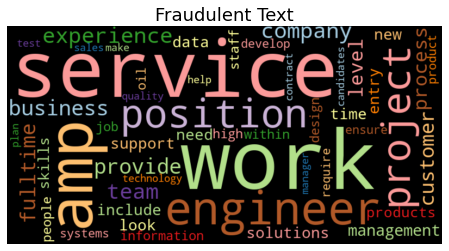

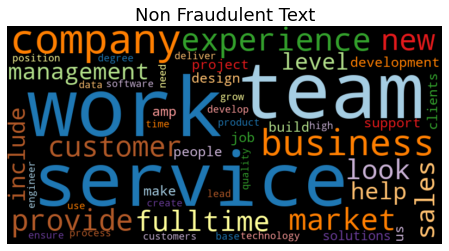

In [50]:
from wordcloud import WordCloud 
#creating word cloud for both real and fake job posting text 

#fake posting 
plt.figure(figsize=(8,4))
fraud_wd= count_words(df_new[df_new['fraudulent']== 1])
wordcloud(fraud_wd['freq'], max_words= 50)
plt.title("Fraudulent Text", size = 18)

#real posting 
plt.figure(figsize=(8,4))
nonfraud_wd= count_words(df_new[df_new['fraudulent']== 0])
wordcloud(nonfraud_wd['freq'], max_words= 50)
plt.title("Non Fraudulent Text", size = 18)

## Sampling techniques

We have class imbalance problem.Therefore we will be comparing the model performances of original distribution with both under sampling and over sampling. 


## Modeling 

### Imbalanced  Data Set

In [51]:
X=df_new.drop(['fraudulent','text', 'token'], axis=1)
y=df_new['fraudulent']

In [52]:
type(X)

pandas.core.frame.DataFrame

In [53]:
X.shape

(17880, 1)

In [54]:
y.shape

(17880,)

## Featuree Engineering 

1) BoW

2) TF-IDF

In [55]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


#tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
#tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(X)
#tfidf_text_vectors.shape

#count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
#count_text_vectors = count_text_vectorizer.fit_transform(X)
#count_text_vectors.shape


#from sklearn.feature_extraction.text import CountVectorizer
#cv = CountVectorizer(max_features = 5000,ngram_range=(1,3))
#X = cv.fit_transform(X).toarray()
#X.shape 


from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer()
#response = vectorizer.fit_transform([X])
#df_tfidf_sklearn = pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names())
#df_tfidf_sklearn
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(X['clean_text'])
tfidf_text_vectors.shape

(17880, 18370)

In [56]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(X['clean_text'])
count_text_vectors.shape



(17880, 18370)

### Train-Test Split

In [57]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tfidf_text_vectors,y, test_size=0.20,random_state=0,stratify=y)



X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(count_text_vectors,y, test_size=0.20,random_state=0,stratify=y)



In [58]:
y_train_tf.value_counts()

0    13611
1      693
Name: fraudulent, dtype: int64

In [59]:
y_train_bow.value_counts()

0    13611
1      693
Name: fraudulent, dtype: int64

In [60]:
#saving clean data on local machine  
df_new.to_csv('/Users/Blaven/Desktop/Capstone Git Storage/clean_df')